I used a gensim pre-trained glove model (glove-wiki-gigaword-200.txt) and some of its words' embeddings (most frequent 8000, to reduce model size), together with a corpus of 9000 London restaurant names and ratings, to train a simple LSTM model that predicts a restaurant's ratings based on its name.

The model is composed of an embedding later (pre-trained), a simple LSTM layer, a dropout layer, and a dense layer.

The performance is ok (given that restaurant names aren't typically very predictive of their performance ... this project is mostly for fun).

In [1]:
# !pip install gensim
# !pip install tensorflowjs

In [2]:
import re
import json
import numpy as np
import pandas as pd
import unicodedata
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflowjs
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

Load the gensim word embedding model.

In [3]:
glove_model = "glove-wiki-gigaword-200.txt"

w2v = KeyedVectors.load_word2vec_format(glove_model,binary=False)

print("Loaded GloVe with vocab size:", len(w2v.index_to_key))

Loaded GloVe with vocab size: 400000


Load the restaurant names and ratings

In [4]:
df1 = pd.read_csv("london_restaurants.csv")
df2 = pd.read_csv("additional.csv")

df = pd.merge(df1, df2, on=['name', 'rating', 'user_ratings_total'], how="outer")
print(df[:5])

                                     name  price_level  rating  \
0    #VIRALMUNCHBOX Sun Sing - 🇨🇳Takeaway          1.0     4.4   
1  'From the Islands', Caribbean Takeaway          NaN     4.2   
2                          'O Ver Borough          2.0     4.5   
3   'O Ver St. James - Italian Restaurant          NaN     4.6   
4                     'Ohanas Cafe Bistro          NaN     4.8   

   user_ratings_total                                     website  \
0                78.0                                         NaN   
1               111.0                                         NaN   
2              1877.0                     https://www.overuk.com/   
3               982.0                     https://www.overuk.com/   
4               242.0  https://www.facebook.com/ohanascafebistro/   

                                             address  postcode  
0                  307 Wood Ln, Dagenham RM8 3NH, UK   RM8 3NH  
1             258 High St, Waltham Cross EN8 7EA, UK   EN8

Preprocess the text:
- normalise to unicode (e.g. é to e)
- remove non-alphanumeric characters

In [5]:
def normalize_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove accents
    text = unicodedata.normalize("NFKD", text)
    text = text.encode("ascii", "ignore").decode("utf-8")

    # Remove non-alphanumeric characters
    text = re.sub(r"[^a-z0-9\s]", "", text)

    return text.split()

df["tokens"] = df["name"].apply(normalize_text)
print(df['tokens'][:5])

0         [viralmunchbox, sun, sing, takeaway]
1    [from, the, islands, caribbean, takeaway]
2                            [o, ver, borough]
3     [o, ver, st, james, italian, restaurant]
4                       [ohanas, cafe, bistro]
Name: tokens, dtype: object


In [6]:
corpus_vocab = set()

for tokens in df["tokens"]:
    corpus_vocab.update(tokens)

print("Corpus vocab size:", len(corpus_vocab))
# print(corpus_vocab)
# print("Malatang in vocab:", "malatang" in corpus_vocab)
# print("Hotpot in vocab:", "hotpot" in corpus_vocab)
# print("Hailidao in vocab:", "haidilao" in corpus_vocab)

Corpus vocab size: 6789


Retrieve the most frequent 8000 words in the glove embedding model.

In [7]:
top_glove_words = set(w2v.index_to_key[:8000])

final_vocab = corpus_vocab.union(top_glove_words)

print("Final vocab size:", len(final_vocab))

Final vocab size: 13587


Add to tokens <PAD> to use when the name's length is shorter than "standard" length when training the model; <UNK> for unknown words.

Then, create a word index that gives each unique word in the corpus an index.

In [8]:
word_index = {
    "<PAD>": 0,
    "<UNK>": 1
}

for word in final_vocab:
    word_index[word] = len(word_index)

vocab_size = len(word_index)
print("Total vocab size:", vocab_size)

Total vocab size: 13589


Create initial embedding matrix.

In [9]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Compute UNK vector (mean of glove vectors)
unk_vector = np.mean(
    [w2v[word] for word in w2v.index_to_key[:50000]],
    axis=0
)

for word, idx in word_index.items():
    if word in w2v:
        embedding_matrix[idx] = w2v[word]
    else:
        embedding_matrix[idx] = unk_vector

In [10]:
max_len = 6

def encode(tokens):
    sequence = []
    for word in tokens:
        if word in word_index:
            sequence.append(word_index[word])
        else:
            sequence.append(word_index["<UNK>"])

    # pad or truncate
    sequence = sequence[:max_len]
    while len(sequence) < max_len:
        sequence.append(word_index["<PAD>"])

    return sequence


Create data. X = the words' embedding, y = log-transformed adjusted rating

In [11]:
df = df.dropna(subset=["rating"])
X = np.array(df["tokens"].apply(encode).tolist())
y = df["rating"].values.astype("float32")

In [91]:
print(sum(y)/len(y))
print(np.std(y))

4.373611
0.39121765


Restaurant ratings are closely clustered around the center (loads of 4.x's), so try to normalise score to improve model.

In [97]:
# use logit transformation
epsilon = 1e-5
y_scaled = (y - 1) / 4   # scale 1–5 scores to 0–1
y_scaled = np.clip(y_scaled, epsilon, 1 - epsilon)
y_transformed = np.log(y_scaled / (1 - y_scaled))

print(y[:50])
print(y_transformed[:50])

[4.4 4.2 4.5 4.6 4.8 4.5 4.4 4.  4.6 4.7 4.4 4.9 5.  4.2 3.6 3.2 4.9 4.7
 4.4 4.4 4.5 4.4 4.5 4.7 4.  4.7 4.7 4.2 4.8 4.5 4.3 4.8 4.8 4.7 4.2 4.7
 4.3 4.6 3.7 4.3 4.3 4.6 4.6 4.  5.  3.6 4.5 4.7 4.2 4.4]
[ 1.7346013   1.386294    1.9459102   2.1972244   2.94444     1.9459102
  1.7346013   1.0986123   2.1972244   2.5123048   1.7346013   3.6635625
 11.511559    1.386294    0.6190391   0.20067078  3.6635625   2.5123048
  1.7346013   1.7346013   1.9459102   1.7346013   1.9459102   2.5123048
  1.0986123   2.5123048   2.5123048   1.386294    2.94444     1.9459102
  1.5505978   2.94444     2.94444     2.5123048   1.386294    2.5123048
  1.5505978   2.1972244   0.73088753  1.5505978   1.5505978   2.1972244
  2.1972244   1.0986123  11.511559    0.6190391   1.9459102   2.5123048
  1.386294    1.7346013 ]


In [101]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_transformed, test_size=0.2, random_state=5
)

Implement the model using tensorflow

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(max_len,)),

    tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False # can't really decide to use True or False, True seems to hurt model performance slightly, but I think true makes some sense since the words in the restaurant names but not in the w2v set were given the average embedding
    ),

    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(1, activation="relu")
])

learning_rate = 0.0001  # default is 0.001, use lower since I have very few data
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    optimizer=optimizer,
    loss="mse",
    metrics=["mae"]
)

model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (None, 6, 200)         │     2,717,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 32)             │        29,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,747,657 (10.48 MB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 2,717,800 (10.37 MB)

In [146]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 5.6601 - mae: 1.6599 - val_loss: 2.7881 - val_mae: 0.8730
Epoch 2/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9921 - mae: 0.9030 - val_loss: 2.6547 - val_mae: 0.8457
Epoch 3/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.8469 - mae: 0.8848 - val_loss: 2.6047 - val_mae: 0.8254
Epoch 4/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.6795 - mae: 0.8439 - val_loss: 2.5769 - val_mae: 0.8083
Epoch 5/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0065 - mae: 0.8833 - val_loss: 2.5606 - val_mae: 0.8019
Epoch 6/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0441 - mae: 0.8725 - val_loss: 2.5494 - val_mae: 0.8042
Epoch 7/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8709 - mae: 0.8723 - val_loss: 2.5410 - val_mae: 0.7864
Epoch 8/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8421 - mae: 0.8442 - val_loss: 2.5384 - val_mae: 0.8081
Epoch 9/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - l

Plot model performance

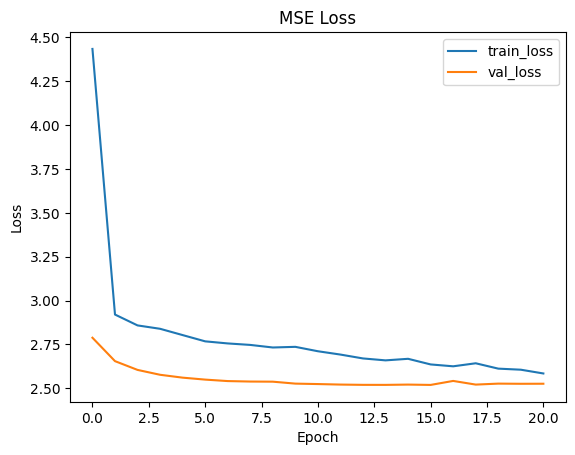

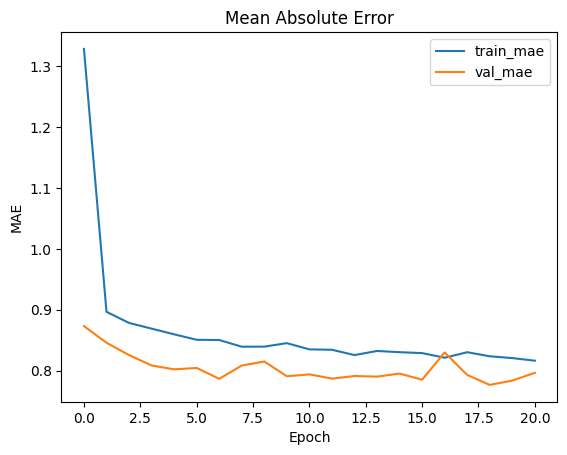

In [147]:
# Loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# MAE
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

Save the model in tensorflow keras format, tensorflow saved model format, then convert to tensorflow.js format

In [114]:
print(tf.version.VERSION)

model.save("restaurant_rating_model.keras")

model.export('saved_model')

# Load model
#model = tf.keras.models.load_model("restaurant_rating_model.keras")

# Check summary
# model.summary()

2.19.0
Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 6), dtype=tf.float32, name='keras_tensor_75')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137862681784400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137862719263504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137862719264656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137862719260624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137862719260816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137862719262544: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [115]:
!tensorflowjs_converter --input_format=tf_saved_model \
    saved_model/ tfjs_model/

2026-02-17 21:45:47.756168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771364747.781242   56893 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771364747.788261   56893 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771364747.806338   56893 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771364747.806385   56893 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771364747.806390   56893 computation_placer.cc:177] computation placer alr

Save the word ids (this is different every time since words was created as a set not a list).

In [116]:
# Save
with open("word_index.json", "w") as f:
    json.dump(word_index, f)

Implement prediction from model.
Add a penalty for unkown words (in case the user input random characters like asedhtioaoqw4).

In [117]:
def predict_rating_with_penalty(name, model, word_index, max_len=6, unk_penalty=2):
    import unicodedata, re
    import numpy as np

    # Normalize text
    name = name.lower()
    name = unicodedata.normalize("NFKD", name)
    name = name.encode("ascii", "ignore").decode("utf-8")
    name = re.sub(r"[^a-z0-9\s]", "", name)
    tokens = name.split()

    # Encode tokens
    sequence = []
    unk_count = 0
    for word in tokens:
        if word in word_index:
            sequence.append(word_index[word])
        else:
            sequence.append(word_index["<UNK>"])
            print("unknown")
            unk_count += 1

    # Pad/truncate
    sequence = sequence[:max_len]
    while len(sequence) < max_len:
        sequence.append(word_index["<PAD>"])

    X_input = np.array([sequence], dtype="int32")

    # Predict
    pred_scaled = model.predict(X_input, verbose=0)[0][0]
    pred = 1 + 4 * (1 / (1 + np.exp(-pred_scaled)))  # inverse logit

    # Apply penalty: pull prediction down for unknown words
    if unk_count > 0:
        penalty = unk_penalty * (unk_count / len(tokens))  # proportional to fraction of unknown words
        pred = pred - penalty

    # Clip to valid rating
    pred = np.clip(pred, 1, 5)
    return round(float(pred), 2)

In [141]:
new_name = input()
rating = predict_rating_with_penalty(new_name, model, word_index)
print(f"Predicted rating for '{new_name}': {rating}")

great london lobster
Predicted rating for 'great london lobster': 4.33
